In [1]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
from Helpers import  (plotting_style, plot_trial_data, timeseriesplot, AV_equalitytest, calculate_pg, generate_levy_AV, generate_mix_samples, levy_dist)
from multisensory_playbook import DetectionTask_versatile, DetectionTask


### Helpers

In [2]:
def plot_stacked_bar(categories, series, labels, colors, title=None, bar_width=0.3):
    """
    Create a stacked bar plot.
    
    :param categories: List of category names
    :param series: List of lists, each containing data for one series
    :param labels: List of labels for each series
    :param colors: List of colors for each series
    :param title: Title of the plot (default: 'Stacked Bar Plot')
    :param bar_width: Width of the bars (default: 0.4)
    """
    x = np.arange(len(categories))
    fig, ax = plt.subplots(figsize=(5, 4))
    
    bottom = np.zeros(len(categories))
    
    for i, data in enumerate(series):
        ax.bar(x, data, bottom=bottom, label=labels[i], color=colors[i], width=bar_width)
        bottom += data
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

### Pseudocode

#### Detection task

In [3]:
def detection_task_demo(n, pm, pe, pn, pc, pi):
    """
    Generate a single trial for the Detection task.

    Parameters:
    n: int - number of time steps
    pm: float - probability of target presence (M != 0)
    pe: float - probability of signal emission when target is present
    pn: float - probability of non-zero observation when no signal is present
    pc: float - probability of correct observation when signal is present
    pi: float - probability of incorrect observation when signal is present

    Returns:
    M: int - target motion direction (-1, 0, or 1)
    E: list - emission states for each time step
    A: list - observations in channel A for each time step
    V: list - observations in channel V for each time step
    """
    # Choose target motion direction
    M = choice([-1, 0, 1], p=[pm/2, 1-pm, pm/2])
    E = []; A = []; V = []

    for t in range(n):
        # Determine if a signal is emitted (depends on M)
        if M:
            e = choice([0, 1], p=[1-pe, pe])
        else:
            e = 0

        # Set distribution for A and V (depends on M and E)
        if e:
            # Signal is emitted
            vals = [-M, 0, M]  # Possible values
            p = [pi, 1-pc-pi, pc]  # Probabilities
        else:
            # No signal or no target
            vals = [-1, 0, 1]
            p = [pn/2, 1-pn, pn/2]

        # Generate observations for A and V
        A.append(choice(vals, p=p))
        V.append(choice(vals, p=p))
        E.append(e)

    return M, E, A, V

#### Time-dependent Detection task

In [4]:
def time_dependent_detection_task_demo(nb_steps, pm, pe, pn, pc, pi, k):
    """
    Generate a single trial for the time-dependent Detection task.
    """
    
    # Choose target motion direction
    M = choice([-1, 0, 1], p=[pm/2, 1-pm, pm/2])

    while True:
        # Generate base emission sequence
        base_e = choice([0, 1], size=nb_steps, p=[1-pe, pe])
        
        # Extend emissions for burst length k
        idx = np.where(base_e == 1)[0]
        fin_e = base_e.copy()
        for i in range(1, k):
            idx_plus = idx + i
            idx_plus = idx_plus[idx_plus < nb_steps]
            fin_e[idx_plus] = 1
        
        # Remove buffer and check if valid
        E = fin_e[k:].tolist()
        if sum(E) > 0:
            break

    # Generate observations
    A = []
    V = []
    for e in E:
        if e:
            vals = [-M, 0, M]
            p = [pi, 1-pc-pi, pc]
        else:
            vals = [-1, 0, 1]
            p = [pn/2, 1-pn, pn/2]
        
        A.append(choice(vals, p=p))
        V.append(choice(vals, p=p))

    return M, A, V, E

### Analysis

#### Detection task

1962 383 7655 -1
1975 408 7617 -1


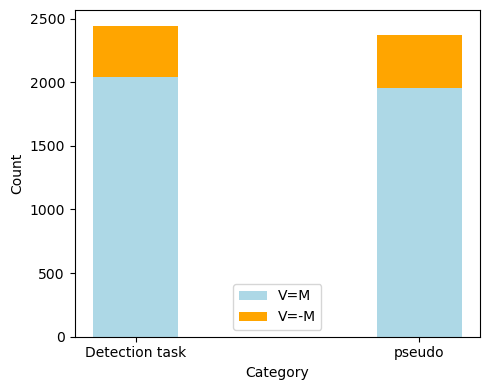

In [5]:
n = 10000
pm = 1 # smaller doesnt mean sparser signals from prey !!!!!!!!
pe = 0.2
pn = 0.1 # smaller = less noisy (more zeros)
pc = 0.8 #0.3
pi = 0. #0.6 
repeats = 1

# Detection task trials
detectask = DetectionTask(pm, pe, pn, pc, pi)
detectrials = detectask.generate_trials(repeats=1, time_steps=n)
M, A, V = detectrials.M[0], detectrials.A[0], detectrials.V[0]

# Pseudo task trials
Mp, Ep, Ap, Vp = detection_task_demo(n, pm, pe, pn, pc, pi)

print(np.count_nonzero(A==M),np.count_nonzero(A==-M),np.count_nonzero(A==0), M)
print(Ap.count(Mp),Ap.count(-Mp),Ap.count(0), Mp)

categories = ['Detection task', 'pseudo']
x = np.arange(len(categories))  # Numerical positions for categories
s1 = [np.count_nonzero(V==M), Vp.count(Mp)]
s2 = [np.count_nonzero(V==-M), Vp.count(-Mp)]
#s3 = [np.count_nonzero(V==0), Vp.count(Mp)]

plot_stacked_bar(
    categories=categories,
    series=[s1, s2],
    labels=['V=M', 'V=-M'],
    colors=['lightblue', 'orange']
    
)


#### Time-dependent Detection task

1931 1568 6496 1
1900 1595 6500 1


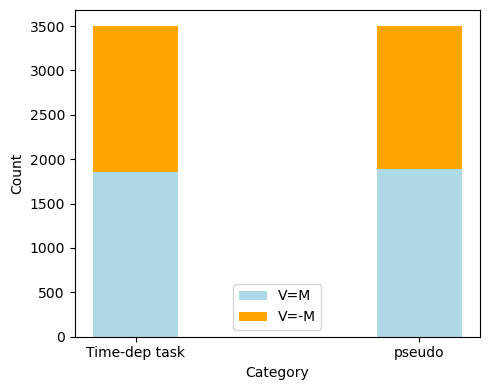

In [6]:
k=5
pe=calculate_pg(0.04,  N=n+1-1, k=k)
pn = 1/3
pi=0.1
timetask = DetectionTask_versatile(pm, pe=pe, pc=pc, pn=pn, pi=pi, time_dep=1, k=k)
timetrials = timetask.generate_trials(nb_trials=1, nb_steps=n)
Mt, At, Vt = timetrials.M[0], timetrials.A[0], timetrials.V[0]

Mtp, Atp, Vtp, Etp = time_dependent_detection_task_demo(nb_steps=n, pm=pm, pe=pe, pn=pn, pc=pc, pi=pi, k=k)

print(np.count_nonzero(At==Mt),np.count_nonzero(At==-Mt),np.count_nonzero(At==0), Mt)
print(Atp.count(Mtp),Atp.count(-Mtp),Atp.count(0), Mtp)

categories = ['Time-dep task', 'pseudo']
x = np.arange(len(categories))  # Numerical positions for categories
s1 = [np.count_nonzero(Vt==Mt), Vtp.count(Mtp)]
s2 = [np.count_nonzero(Vt==-Mt), Vtp.count(-Mtp)]
plot_stacked_bar(
    categories=categories,
    series=[s1, s2],
    labels=['V=M', 'V=-M'],
    colors=['lightblue', 'orange']
    
)

#### Levy flight

10007
2120 1647 6233 1
2041 1631 6328 1


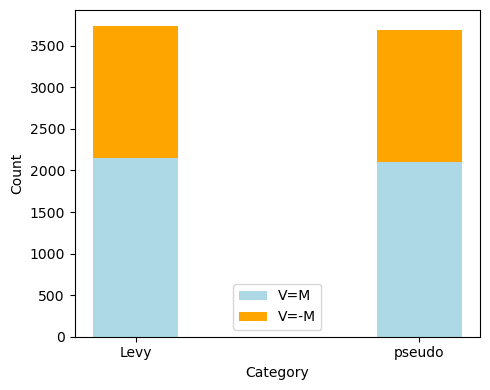

In [20]:
total_sequence_length = n
emission_probability = 0.04
lmax = 8

#n = total_sequence_length
pe_sparse = emission_probability
N = n + lmax - 1
print(N)
num_nonzero = np.random.binomial(N, pe_sparse)
E_starts = np.random.choice(np.arange(N), size=num_nonzero, replace=False)

L = np.random.choice(np.arange(lmax + 1), size=num_nonzero, p=levy_dist(lmax))
E = np.zeros(N, dtype=bool)
for e_start, l in zip(E_starts, L):
    E[e_start:e_start+l] = 1
E = E[lmax-1:]
Mlp = 1
def generate_obs(E, M, pc, pi, pn):
    return [np.random.choice([-M, 0, M], p=[pi, 1-pc-pi, pc]) if e else
            np.random.choice([-1, 0, 1], p=[pn/2, 1-pn, pn/2]) for e in E]

Vlp = generate_obs(E, Mlp, pc, pi, pn)

# Original code
pl = levy_dist(lmax)
E = generate_mix_samples(pg=pe_sparse, pl=pl, N=n, repeats=1)
Ml, Al, Vl, El = generate_levy_AV(pm, pn, pi, pc, nb_trials=1, nb_steps=n, E=E)

print(np.count_nonzero(Al==Ml),np.count_nonzero(Al==-Ml),np.count_nonzero(Al==0), Mt)
print(Alp.count(Mlp),Alp.count(-Mlp),Alp.count(0), Mlp)
categories = ['Levy', 'pseudo']
x = np.arange(len(categories))  # Numerical positions for categories
s1 = [np.count_nonzero(Vl==Ml), Vlp.count(Mlp)]
s2 = [np.count_nonzero(Vl==-Ml), Vlp.count(-Mlp)]
plot_stacked_bar(
    categories=categories,
    series=[s1, s2],
    labels=['V=M', 'V=-M'],
    colors=['lightblue', 'orange']
    
)